In [1]:
! pip install catboost
! pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from deap import base, creator, tools
from scipy.stats import randint, uniform, loguniform
import random
import multiprocessing
import time

random.seed(42)

In [3]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/antbartash/australian_rain/main/data/data_transformed.csv',
    index_col=0
)
X, y = data.drop(columns=['RainTomorrow', 'RainToday']), data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    X_train[column] = X_train[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))
    X_test[column] = X_test[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    objective='Logloss',
    random_state=42, verbose=False, task_type='GPU'#, gpu_ram_part=0.15, used_ram_limit='2gb'
)

In [4]:
# GA parameters
NPOP = 10 # population size
NGEN = 40 # number of trials
CXPB = 0.5 # crossover probability
MUTPB = 0.2 # mutation probability

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

In [5]:
# Register hyperparameters with their distributions
PARAM_NAMES = [
    'n_estimators', 'learning_rate', 'depth', 'l2_leaf_reg',
    'bagging_temperature', 'grow_policy', 'scale_pos_weight'
]
toolbox.register('n_estimators', randint.rvs, 10, 500)
toolbox.register('learning_rate', loguniform.rvs, 1e-6, 0.5)
toolbox.register('depth', randint.rvs, 1, 8)
toolbox.register('l2_leaf_reg', uniform.rvs, 0.0, 100.0)
toolbox.register('bagging_temperature', uniform.rvs, 0.0, 100.0)
toolbox.register('grow_policy', random.choice, ['SymmetricTree', 'Depthwise'])
toolbox.register('scale_pos_weight', uniform.rvs, 1.0, 4.0)

In [6]:
# Define the genes of an individual and register the population
toolbox.register(
    'individual', tools.initCycle, creator.Individual,
    (toolbox.n_estimators, toolbox.learning_rate, toolbox.depth, toolbox.l2_leaf_reg,
     toolbox.bagging_temperature, toolbox.grow_policy, toolbox.scale_pos_weight)
)
toolbox.register('population', tools.initRepeat, list, toolbox.individual, n=5)

In [7]:
toolbox.individual()

[162,
 1.7335453460230782e-06,
 2,
 87.3814011129385,
 42.17318085618216,
 'SymmetricTree',
 3.0220670415337367]

In [8]:
toolbox.population()

[[263,
  0.2690501540569653,
  6,
  70.95548228663597,
  29.60381582637036,
  'SymmetricTree',
  2.8079405910632214],
 [375,
  0.00018024592631136148,
  3,
  40.144782498718016,
  63.07658068905053,
  'Depthwise',
  4.771734630206094],
 [14,
  0.005637005206986633,
  7,
  42.495840884647286,
  98.57338342458635,
  'SymmetricTree',
  3.822207914182469],
 [307,
  0.000258375795923692,
  7,
  52.17560326092359,
  43.16367459891581,
  'SymmetricTree',
  2.6313288881517956],
 [123,
  0.0001339947068415134,
  3,
  78.6710027190945,
  52.84987372502555,
  'SymmetricTree',
  1.296019075303485]]

In [9]:
# Implement a custom mutation strategy (DEAP strategies are suitable only for floating and binary values)
def mutPolynomialBoundedMix(individual, eta, low, up, is_int, indpb, discrete_params):
    for i in range(len(individual)):
        if discrete_params[i]:
            if random.random() < indpb:
                individual[i] = random.choice(discrete_params[i])
        else:
            individual[i] = tools.mutPolynomialBounded(
                [individual[i]],  eta[i], low[i], up[i], indpb
            )[0][0]
        if is_int[i]:
            individual[i] = int(individual[i])
    return individual

In [10]:
# Register strategies
#     'n_estimators', 'learning_rate', 'depth', 'l2_leaf_reg',
#     'bagging_temperature', 'grow_policy', 'scale_pos_weight'
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('mate', tools.cxUniform, indpb=CXPB)
toolbox.register('mutate', mutPolynomialBoundedMix,
                 eta=[0.01, 0.01, 0.01, 0.01, 0.01, None, 0.01],
                 low=[10, 1e-6, 1, 0.0, 0.0, None, 1.0],
                 up=[500, 0.5, 8, 100.0, 100.0, None, 4.0],
                 is_int = [True, False, True, False, False, False, False],
                 indpb = MUTPB,
                 discrete_params=[[], [], [], [], [],
                                  ['SymmetricTree', 'Depthwise'],
                                  []])

In [11]:
def evaluate(individual):
    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}
    if strategy_params['scale_pos_weight'] < 1:
        return [-np.inf]
    tuned_model = clone(model).set_params(**strategy_params)
    score = np.mean(cross_val_score(tuned_model, X_train, y_train, cv=3, scoring='roc_auc'))
    return score

toolbox.register('evaluate', evaluate)

In [12]:
pool = multiprocessing.Pool(1)
toolbox.register('map', pool.map)

In [13]:
mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)
pop = toolbox.population(n=NPOP)
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")

for g in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = [fit]

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        f"\nHALL OF FAME - generation {g} - {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

Start time: 2024-01-03 12:40:01

HALL OF FAME - generation 0 - 2024-01-03 12:42:03:
    0: [447, 3.3624119093541463e-06, 6, 8.17142695386811, 23.62428628066453, 'SymmetricTree', 1.0220488782440902], Fitness: 0.846949546323172
    1: [450, 0.0015078340181674348, 3, 79.6907676126998, 11.950416092988824, 'SymmetricTree', 4.822210920146424], Fitness: 0.8407318824856214
    2: [86, 0.0004314777150938274, 2, 62.39919957058967, 21.73876661025742, 'SymmetricTree', 1.7228581038072264], Fitness: 0.8363460121250808

HALL OF FAME - generation 1 - 2024-01-03 12:42:57:
    0: [447, 3.3624119093541463e-06, 6, 8.17142695386811, 23.62428628066453, 'SymmetricTree', 1.0220488782440902], Fitness: 0.846949546323172
    1: [447, 3.3624119093541463e-06, 6, 62.39919957058967, 23.62428628066453, 'SymmetricTree', 1.7228581038072264], Fitness: 0.8465743157447706
    2: [450, 0.0015078340181674348, 3, 79.6907676126998, 11.950416092988824, 'SymmetricTree', 4.822210920146424], Fitness: 0.8407318824856214

HALL OF F

In [14]:
params = {}
for idx_hof, param_name in enumerate(PARAM_NAMES):
    params[param_name] = hall_of_fame[0][idx_hof]

params

{'n_estimators': 469,
 'learning_rate': 0.11859089833185385,
 'depth': 7,
 'l2_leaf_reg': 88.39739275901474,
 'bagging_temperature': 0.21477987026071643,
 'grow_policy': 'SymmetricTree',
 'scale_pos_weight': 1.7228581038072264}

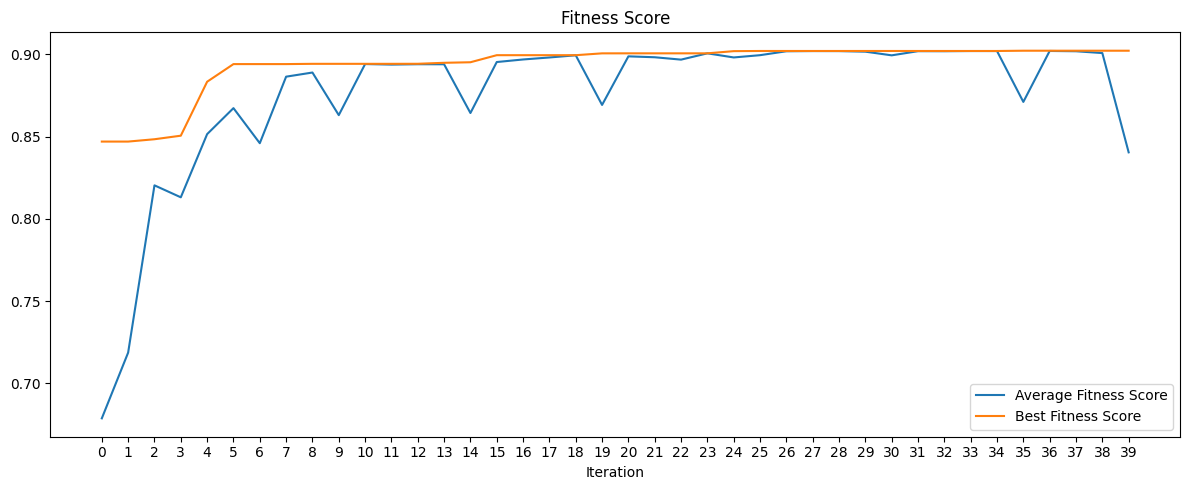

In [17]:
fig, ax = plt.subplots(sharex=True, figsize=(12, 5))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")
plt.tight_layout()
plt.show()

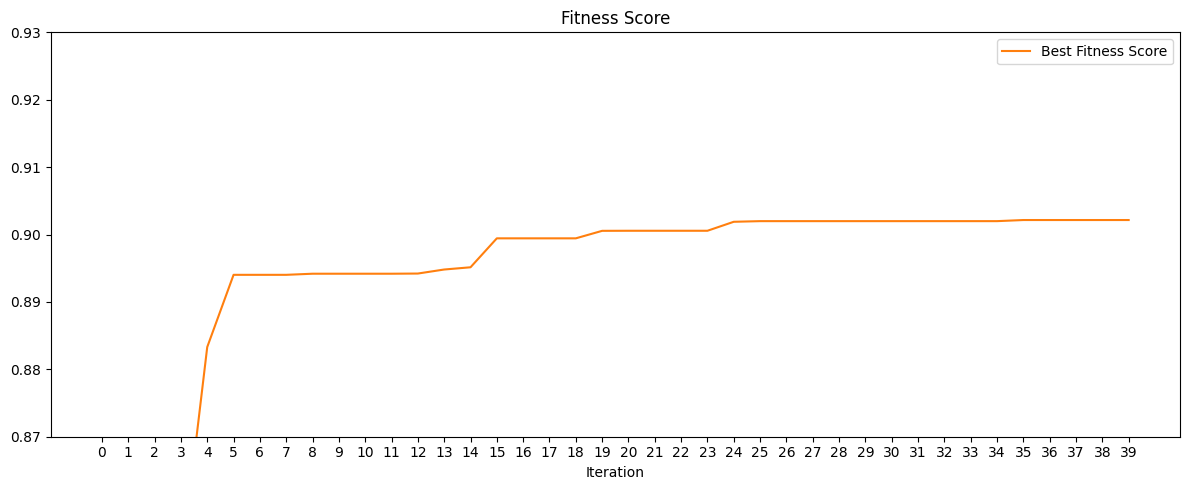

In [22]:
fig, ax = plt.subplots(sharex=True, figsize=(12, 5))
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score", color='tab:orange')
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")
ax.set_ylim(0.87, 0.93)
plt.tight_layout()
plt.show()